> **Note:** In most sessions you will be solving exercises posed in a Jupyter notebook that looks like this one. Because you are cloning a Github repository that only we can push to, you should **NEVER EDIT** any of the files you pull from Github. Instead, what you should do, is either make a new notebook and write your solutions in there, or **make a copy of this notebook and save it somewhere else** on your computer, not inside the `sds` folder that you cloned, so you can write your answers in there. If you edit the notebook you pulled from Github, those edits (possible your solutions to the exercises) may be overwritten and lost the next time you pull from Github. This is important, so don't hesitate to ask if it is unclear.

#  Exercise Set 2: Regularization and cross-validation
In this exercise set you will learn work with linear regression models to learn more about:
- regularization
- cross-validation 
- over/underfitting 

We import our standard stuff. Notice that we are not interested in seeing the convergence warning in scikit-learn so we suppress them for now.

In [15]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

%matplotlib inline

## Modelling houseprices
In this example we will try to predict houseprices using a lot of variable (or features as they are called in Machine Learning). We are going to work with Kaggle's dataset on house prices, see information [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Kaggle is an organization that hosts competitions in building predictive models.

> **Ex. 2.1.0:** Load the california housing data with scikit-learn using the code below. Inspect the data set. 

In [16]:
# [Answer to Ex. 2.1.0]

In [17]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

cal_house = fetch_california_housing()    
X = pd.DataFrame(data=cal_house['data'], 
                 columns=cal_house['feature_names'])\
             .iloc[:,:-2]
y = cal_house['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1)

X_train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
count,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000
mean,3.874334,28.506977,5.448060,1.098334,1426.466860,3.046432
std,1.875069,12.638869,2.710030,0.543761,1098.387561,7.727201
min,0.499900,1.000000,0.888889,0.333333,5.000000,1.060606
25%,2.579425,18.000000,4.462767,1.006410,787.750000,2.428799
50%,3.549850,29.000000,5.235723,1.048780,1162.500000,2.822316
75%,4.736450,37.000000,6.070853,1.098592,1726.250000,3.281516
max,15.000100,52.000000,141.909091,34.066667,16305.000000,599.714286




> **Ex.2.2.1**: Generate interactions between all features to third degree, make sure you **exclude** the bias/intercept term. How many variables are there? Will OLS fail? 

> After making interactions rescale the features to have zero mean, unit std. deviation. Should you use the distribution of the training data to rescale the test data?  

>> *Hint 1*: Try importing `PolynomialFeatures` from `sklearn.preprocessing`

>> *Hint 2*: If in doubt about which distribution to scale, you may read [this post](https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i).

In [18]:
# [Answer to Ex. 2.1.1]

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# polynomial transformation
poly_trans = PolynomialFeatures(degree=3, include_bias=True)
X_train_p = poly_trans.fit_transform(X_train)
X_test_p = poly_trans.fit_transform(X_test)

print(X_train_p.shape)
# X_train_p has 83 features, and 10320 rows. Because features < rows, OLS would not fail.
# Note that OLS may become computationally intractable before it fails due 
# to quadratic scaling in computation time.

# rescaling data: we use the distribution of the test data
rescaler = StandardScaler().fit(X_train_p)    

X_train2 = rescaler.transform(X_train_p)
X_test2 = rescaler.transform(X_test_p)

(10320, 84)


> **Ex.2.2.2**: Estimate the Lasso model on the rescaled train data set, using values of $\lambda$ in the range from $10^{-4}$ to $10^4$. For each $\lambda$  calculate and save the Root Mean Squared Error (RMSE) for the rescaled test and train data. 

> *Hint*: use `logspace` in numpy to create the range.


In [20]:
# [Answer to Ex. 2.1.2]

In [21]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse

def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

output = []

lambdas =  np.logspace(-4, 4, 20)

for lambda_ in lambdas:
        
    reg = Lasso(alpha=lambda_, random_state=1)
    reg.fit(X_train2, y_train)
    
 
    
    output.append([lambda_,
                   rmse(reg.predict(X_train2), y_train),
                   rmse(reg.predict(X_test2), y_test)])

> **Ex.2.2.3**: Make a plot with on the x-axis and the RMSE measures on the y-axis. What happens to RMSE for train and test data as $\lambda$ increases? The x-axis should be log scaled. Which one are we interested in minimizing? 

> Bonus: Can you find the lambda that gives the lowest MSE-test score?

In [22]:
# [Answer to Ex. 2.1.3]

Minimum RMSE = 0.783 found for lambda = 0.0127.


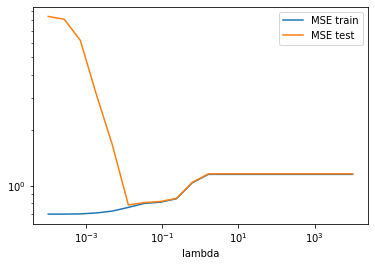

In [23]:
MSE_df = pd.DataFrame(data=output, 
                      columns=['lambda', 'MSE train', 'MSE test'])\
           .set_index('lambda')    

MSE_df.plot(logx=True, logy=True)

# find the minimal observations as a series
best_fit = MSE_df['MSE test'].nsmallest(1)

# We are interested in minimizing the MSE test
# because this tells us 
# how well out model perform out of sample. 

# take out the data minimum RMSE and the optimal lambda 
lambda_opt, RMSE_min = next(best_fit.items()) 
print('Minimum RMSE = %.3f found for lambda = %.4f.' % (RMSE_min, lambda_opt))

### Model building with pipelines

A powerful tool for making and applying models are pipelines, which allows to combine different preprocessing and model procedures into one. This has many advantages, mainly being more safe but also has the added side effect being more code-efficient.

> **Ex. 2.1.4:** Construct a model building pipeline which 

> 1. adds polynomial features of degree 3 without bias;
> 1. scales the features to mean zero and unit std. 

>> *Hint:* a modelling pipeline can be constructed with `make_pipeline` from `sklearn.pipeline`.

In [24]:
# [Answer to Ex. 2.1.4]

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

pipe_prep = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),                           
                          StandardScaler())

# Model selection and validation


### Simple validation
In machine learning, we have two types of parameters: those that are learned from
the training data, for example, the weights in logistic regression, and the parameters
of a learning algorithm that are optimized separately. The latter are the tuning
parameters, also called *hyperparameters*, of a model, for example, the regularization
parameter in logistic regression or the depth parameter of a decision tree.


In what follows we will regard the "train" (aka. development, non-test) data for two purposes. 
- First we are interested in getting a credible measure of models under different hyperparameters to perform a model selection. 
- Then with the selected model we estimate/train it on all the training data. 

> **Ex. 2.1.5:** Make a for loop with 10 iterations where you:
1. Split the input data into, train (also know as development) and test where the test sample should be one third. (Set a new random state for each iteration of the loop, so each iteration makes a different split).
2. Further split the training (aka development) data into to even sized bins; the first data is for training models and the other is for validating them. (Therefore these data sets are often called training and validation)
3. Train a linear regression model with sub-training data. Compute the RMSE for out-of-sample predictions for both the test data  and the validation data. Save the RMSE.

> You should now have a 10x2 DataFrame with 10 RMSE from both the test data set and the train data set. Compute descriptive statistics of RMSE for the out-of-sample predictions on test and validation data. Are they simular?    
>   They hopefuly are pretty simular. This shows us, that we can split the train data, and use this to fit the model. 

>> *Hint*: you can reuse code from earlier exercises. 

In [26]:
# [Answer to Ex. 2.1.5]

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

output = []

for random_state in range(10):
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=random_state)    
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=random_state)

    reg = LinearRegression().fit(X_train, y_train)
    reg.predict(X_test)

    output.append([rmse(reg.predict(X_val), y_val),
                   rmse(reg.predict(X_test), y_test)])
    
pd.DataFrame(output, columns=['test', 'validation']).describe()

,test,validation
count,10.000000,10.000000
mean,1.143827,1.101885
std,0.978098,0.658022
min,0.777620,0.773043
25%,0.781633,0.787416
50%,0.794827,0.794032
75%,0.800074,0.809688
max,3.899375,2.504750


> **Ex. 2.1.6:** Construct a model building pipeline which 

> 1. adds polynomial features of degree 3 without bias;
> 1. scales the features to mean zero and unit std. 
> 1. estimates a Lasso model

In [28]:
# [Answer to Ex. 2.1.6]

In [29]:
from sklearn.linear_model import Lasso

pipe_lasso = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),                           
                           StandardScaler(),
                           Lasso(random_state=1))

### Cross validation

  
The simple validation procedure that we outlined above has one disadvantage: it only uses parts of the *development* data for validation.


When we want to optimize over both normal parameters and hyperparameteres we do this using nested loops (two-layered cross validation). In outer loop we vary the hyperparameters, and then in the inner loop we do cross validation for the model with the specific selection of hyperparameters. This way we can find the model, with the lowest mean MSE. 

> **Ex. 2.1.7:**
Run a Lasso regression using the Pipeline from `Ex 2.1.4`. In the outer loop searching through the lambdas specified below. 
In the inner loop make *5 fold cross validation* on the selected model and store the average MSE for each fold. Which lambda, from the selection below, gives the lowest test MSE?
 ```python 
lambdas =  np.logspace(-4, 4, 12)
```
 *Hint:* `KFold` in `sklearn.model_selection` may be useful.

In [30]:
# [Answer to Ex. 2.1.7]

In [31]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=5)
lambdas =  np.logspace(-4, 4, 12)
mses = []

for lambda_ in lambdas:
    
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))    
    mses_test = []
    mses_train = []
    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        
        X_train, y_train, = X_dev.iloc[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx] 

        pipe_lasso.fit(X_train, y_train)
        
        mses_train.append(mse(pipe_lasso.predict(X_train), y_train))
        mses_test.append(mse(pipe_lasso.predict(X_val), y_val))
                
    mses.append([sum(mses_train)/len(mses_train),sum(mses_test)/len(mses_test),lambda_])
    
mses    

[[0.4812941870205839, 0.6266458366460249, 0.0001],
 [0.48368663031030124, 2.7204993205406627, 0.0005336699231206312],
 [0.5049716824487993, 0.9900417720540275, 0.002848035868435802],
 [0.5726973327865992, 0.57963343656599, 0.01519911082952933],
 [0.6610452974993936, 0.6623662882828436, 0.08111308307896872],
 [0.88252082505152, 0.883206225220402, 0.43287612810830617],
 [1.3231104986395466, 1.3232488853041051, 2.310129700083158],
 [1.3231104986395466, 1.3232488853041051, 12.32846739442066],
 [1.3231104986395466, 1.3232488853041051, 65.79332246575683],
 [1.3231104986395466, 1.3232488853041051, 351.11917342151344],
 [1.3231104986395466, 1.3232488853041051, 1873.8174228603868],
 [1.3231104986395466, 1.3232488853041051, 10000.0]]

### Tools for model selection

Below we review three useful tools for performing model selection. The first tool, the learning curve, can be used to assess whether there is over- and underfitting.

> **Ex. 2.1.8:** __Automated Cross Validation in one dimension__  
Now we want to repeat exercise 12.1.4 in a more automated fasion. 
When you are doing cross validation with one hyperparameter, you can automate the process by using `validation_curve` from `sklearn.model_selection`. Use this function to search through the values of lambda, and find the value of lambda, which give the lowest test error.  

> check if you got the same output for the manual implementation (Ex. 2.1.6) and the automated implementation (Ex. 2.1.7) 

> BONUS: Plot the average MSE-test and MSE-train against the different values of lambda. (*Hint*: Use logarithmic axes, and lambda as index)

In [32]:
# [Answer to Ex. 2.1.8]

In [33]:
from sklearn.model_selection import validation_curve

lambdas =  np.logspace(-4, 4, 12)

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_train,
                     y=y_train,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',# scoring='neg_mean_squared_error',                 
                     cv=5)

mean_values = pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
                         'test': pd.DataFrame(-test_scores).mean(1), 
                         'lambda': pd.DataFrame(lambdas).mean(1)}, axis =1)

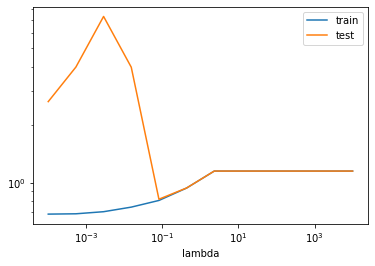

In [34]:
# answer to plotting bonus question

from sklearn.metrics import mean_squared_error as mse

def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))


# plot the 
pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
           'test': pd.DataFrame(-test_scores).mean(1)},
           axis=1)\
    .pipe(np.sqrt)\
    .set_index(pd.Index(lambdas, name='lambda'))\
    .plot(logx=True, logy=True)

plt.show()

When you have *more than one* hyperparameter, you will want to fit the model to all the possible combinations of hyperparameters. This is done in an approch called `Grid Search`, which is implementet in `sklearn.model_selection` as `GridSearchCV`

> **Ex. 2.1.9:** To get to know `Grid Search` we want to implement in one dimension. Using `GridSearchCV` implement the Lasso, with the same lambdas as before (`lambdas =  np.logspace(-4, 4, 12)`), 10-fold CV and (negative) mean squared error as the scoring variable. Which value of Lambda gives the lowest test error? 

In [35]:
# [Answer to Ex. 2.1.9]

In [36]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(estimator=pipe_lasso, 
                  param_grid=[{'lasso__alpha':lambdas}], 
                  scoring='neg_mean_squared_error', 
                  cv=10, 
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_params_)

{'lasso__alpha': 0.08111308307896872}


> **Ex. 2.1.10 BONUS** Expand the Lasso pipe from the last excercise with a Principal Component Analisys (PCA), and expand the Grid Search to searching in two dimensions (both along the values of lambda and the values of principal components (n_components)). Is `n_components` a hyperparameter? Which hyperparameters does the Grid Search select as the best?

> NB. This might take a while to calculate. 

In [37]:
# [Answer to Ex. 2.1.10]

In [38]:
from sklearn.decomposition import PCA

pipe_sq_pca_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                                  StandardScaler(),
                                  PCA(),
                                  Lasso())


gs = GridSearchCV(estimator=pipe_sq_pca_lasso, 
                  param_grid=[{'lasso__alpha':lambdas, 
                               'pca__n_components':range(1, X_train.shape[1]+1)}], 
                  scoring='neg_mean_squared_error', 
                  cv=10, 
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
# Yes, n_components is a hyperparameter. 
print(gs.best_params_)

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'lasso__alpha': 0.002848035868435802, 'pca__n_components': 6}


> **Ex. 2.1.11 BONUS** repeat the previous now with RandomizedSearchCV with 20 iterations.

In [39]:
# [Answer to Ex. 2.1.11]

In [42]:
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

pipe_sq_pca_lasso = make_pipeline(PolynomialFeatures(degree=2,
                                                     include_bias=False), 
                                  StandardScaler(),
                                  PCA(),
                                  Lasso())


gs = RandomizedSearchCV(estimator=pipe_sq_pca_lasso, 
                        param_distributions=[{'lasso__alpha':lambdas, 
                                              'pca__n_components':range(1, X_train.shape[1]+1)}], 
                        scoring='neg_mean_squared_error', 
                        cv=10, 
                        n_jobs=-1,
                        n_iter=20)

gs = gs.fit(X_train, y_train)
# Yes, n_components is a hyperparameter. 
print(gs.best_params_)

{'pca__n_components': 6, 'lasso__alpha': 0.002848035868435802}




> **Ex. 2.1.12 BONUS** read about nested cross validation. How might we implement this in answer 2.1.9?


In [ ]:
# [Answer to Ex. 2.1.12]